In [1]:
import pandas as pd 
import janitor

def get_data():
    URL_CSV="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
    df = pd.read_csv(URL_CSV)
    df['Country/Region'] = df['Country/Region'].replace({'US':'United States of America'})
    return df
df = get_data()
df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,10/14/20,10/15/20,10/16/20,10/17/20,10/18/20,10/19/20,10/20/20,10/21/20,10/22/20,10/23/20
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,39994,40026,40073,40141,40200,40287,40357,40510,40626,40687
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,15955,16212,16501,16774,17055,17350,17651,17948,18250,18556
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,53584,53777,53998,54203,54402,54616,54829,55081,55357,55630
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,3190,3190,3377,3377,3377,3623,3623,3811,3811,4038
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,6846,7096,7222,7462,7622,7829,8049,8338,8582,8829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,45658,46100,46434,46746,47135,47616,48129,48628,49134,49579
263,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,...,10,10,10,10,10,10,10,10,10,10
264,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,2053,2053,2055,2055,2056,2056,2057,2057,2057,2060
265,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,15616,15659,15659,15789,15853,15897,15982,16000,16035,16095


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1,2020-01-23,-7.101661e+03,0.000000e+00,1.820658e+05,-7.101661e+03,-7.101661e+03,11563.557943,11563.557943,11563.557943,11563.557943,11563.557943,11563.557943,0.0,0.0,0.0,4.461897e+03
2,2020-01-24,-4.373071e+03,0.000000e+00,1.979456e+05,-4.373071e+03,-4.373071e+03,34079.470537,34079.470537,34079.470537,34079.470537,34079.470537,34079.470537,0.0,0.0,0.0,2.970640e+04
3,2020-01-25,-1.644481e+03,0.000000e+00,1.726158e+05,-1.644481e+03,-1.644481e+03,10639.866610,10639.866610,10639.866610,10639.866610,10639.866610,10639.866610,0.0,0.0,0.0,8.995386e+03
7,2020-01-29,9.269880e+03,0.000000e+00,1.819853e+05,9.269880e+03,9.269880e+03,-7968.558118,-7968.558118,-7968.558118,-7968.558118,-7968.558118,-7968.558118,0.0,0.0,0.0,1.301322e+03
8,2020-01-30,1.199847e+04,0.000000e+00,2.077877e+05,1.199847e+04,1.199847e+04,11563.557943,11563.557943,11563.557943,11563.557943,11563.557943,11563.557943,0.0,0.0,0.0,2.356203e+04
9,2020-01-31,1.472706e+04,0.000000e+00,2.184290e+05,1.472706e+04,1.472706e+04,34079.470537,34079.470537,34079.470537,34079.470537,34079.470537,34079.470537,0.0,0.0,0.0,4.880653e+04
10,2020-02-01,1.745564e+04,0.000000e+00,1.911814e+05,1.745564e+04,1.745564e+04,10639.866610,10639.866610,10639.866610,10639.866610,10639.866610,10639.866610,0.0,0.0,0.0,2.809550e+04
11,2020-02-02,2.018422e+04,0.000000e+00,1.912782e+05,2.018422e+04,2.018422e+04,-8732.309838,-8732.309838,-8732.309838,-8732.309838,-8732.309838,-8732.309838,0.0,0.0,0.0,1.145191e+04
12,2020-02-03,2.291279e+04,0.000000e+00,1.752047e+05,2.291279e+04,2.291279e+04,-18812.429859,-18812.429859,-18812.429859,-18812.429859,-18812.429859,-18812.429859,0.0,0.0,0.0,4.100363e+03
13,2020-02-04,2.564137e+04,0.000000e+00,1.956497e+05,2.564137e+04,2.564137e+04,-20769.597274,-20769.597274,-20769.597274,-20769.597274,-20769.597274,-20769.597274,0.0,0.0,0.0,4.871773e+03


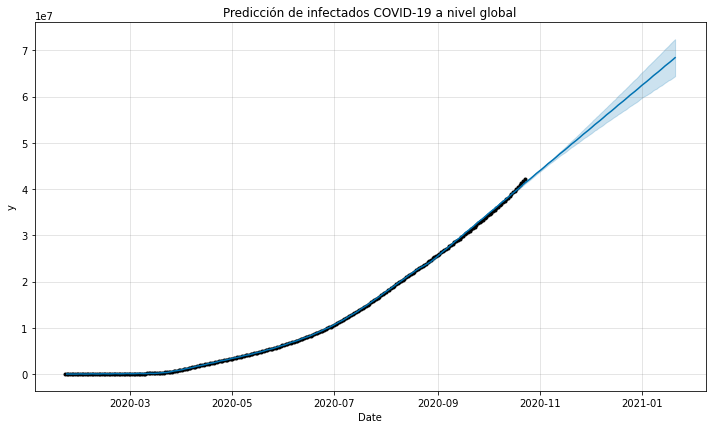

In [2]:
import janitor
import pandas as pd
import pandas_flavor as pf
import fbprophet
from matplotlib import pyplot as plt    
from IPython.display import display, HTML



LISTA_COLUMNAS_A_BORRAR = ['Province/State', 'Country/Region', 'Lat', 'Long']



df = get_data()
df = df.remove_columns(LISTA_COLUMNAS_A_BORRAR)
df
df = pd.DataFrame( df.sum())
df.columns=['y']
df.index = pd.to_datetime(df.index)  
df['ds'] = df.index
df = df.reset_index()


df = df.remove_columns(['index'])


df_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
df_prophet.fit(df)

df_forecast = df_prophet.make_future_dataframe(periods=90, freq='D')
# Make predictions
df_forecast = df_prophet.predict(df_forecast)
df_forecast

df_forecast = df_forecast[df_forecast["yhat"] >= 0]
df_forecast.loc[df_forecast.yhat_lower < 0, 'yhat_lower'] = 0


df_prophet.plot(df_forecast, xlabel = 'Date' )
plt.title('Predicción de infectados COVID-19 a nivel global'   )

display(HTML(pd.DataFrame(df_forecast).to_html()))


In [3]:
df = get_data()
df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,10/14/20,10/15/20,10/16/20,10/17/20,10/18/20,10/19/20,10/20/20,10/21/20,10/22/20,10/23/20
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,39994,40026,40073,40141,40200,40287,40357,40510,40626,40687
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,15955,16212,16501,16774,17055,17350,17651,17948,18250,18556
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,53584,53777,53998,54203,54402,54616,54829,55081,55357,55630
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,3190,3190,3377,3377,3377,3623,3623,3811,3811,4038
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,6846,7096,7222,7462,7622,7829,8049,8338,8582,8829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,45658,46100,46434,46746,47135,47616,48129,48628,49134,49579
263,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,...,10,10,10,10,10,10,10,10,10,10
264,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,2053,2053,2055,2055,2056,2056,2057,2057,2057,2060
265,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,15616,15659,15659,15789,15853,15897,15982,16000,16035,16095


In [4]:

import janitor
import datetime
import numpy as np

def pipeline_populations():
    """ Cogemos un dataframe de poblaciones"""

    URL="https://population.un.org/wpp/Download/Files/1_Indicators%20(Standard)/CSV_FILES/WPP2019_TotalPopulationBySex.csv"
    THIS_YEAR = datetime.datetime.now().year

    return (
        pd.read_csv(URL)
        .filter_on( f""" Time  ==  {THIS_YEAR} & Variant == "Medium" """ ) 
        .select_columns(['Location','PopTotal'])
        .join_apply(lambda x: x['PopTotal'] * 1000 , new_column_name="PopMillions" )
        .remove_columns(['PopTotal'])
        .rename_column('PopMillions' , 'PopTotal')
        .transform_column('PopTotal',np.int64)
        .rename_column('Location' , 'Country/Region')
    )


populations = pipeline_populations()
populations

,Country/Region,PopTotal
70,Afghanistan,38928341
954,Africa,1340598113
1838,African Group,1338826591
1989,African Union,1339423920
2140,African Union: Central Africa,158619638
...,...,...
277315,World,7794798728
278199,World Bank Regional Groups (developing only),6528762227
278350,Yemen,29825967
279234,Zambia,18383956


In [5]:
df = get_data()
df_country = pd.DataFrame()
df_country['Country/Region'] = df['Country/Region']
df_country['infected last_day'] = df.iloc[:,-1] - df.iloc[:,-2]
df_country.set_index('Country/Region')
df_country

,Country/Region,infected last_day
0,Afghanistan,61
1,Albania,306
2,Algeria,273
3,Andorra,227
4,Angola,247
...,...,...
262,West Bank and Gaza,445
263,Western Sahara,0
264,Yemen,3
265,Zambia,60


In [6]:
df_country_enrich = pd.merge(df_country, populations, on="Country/Region")
df_country_enrich['Infected/Million'] =  1000000 * df_country_enrich['infected last_day'] / df_country_enrich['PopTotal'] 
df_country = df_country_enrich

In [7]:
df_country.sort_values(by='Infected/Million', ascending=False).head(10)

,Country/Region,infected last_day,PopTotal,Infected/Million
3,Andorra,227,77265,2937.940853
23,Belgium,17568,11589616,1515.839697
92,Czechia,15258,10708982,1424.785288
154,Liechtenstein,42,38137,1101.292708
7,Armenia,2474,2963234,834.898628
156,Luxembourg,518,625976,827.507764
208,Slovenia,1661,2078932,798.967932
218,Switzerland,6634,8654618,766.527188
119,France,41816,65273512,640.627396
177,Netherlands,9996,17134873,583.371701


In [8]:
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.dates as mdates


def pintar_grafico(df, array_naciones_pintar ,title):
    df = df.T
    df = df.iloc[1:]
    new_header = df.iloc[0] #grab the first row for the header
    df = df[1:] #take the data less the header row
    df.columns = new_header #set the header row as the df header
    df = df.iloc[2:]
    df.index = pd.to_datetime(df.index)
    df = df[array_naciones_pintar]
    df = df.iloc[:, : 9]
    chart_df = df

    pd.plotting.register_matplotlib_converters()
    chart_df.plot(legend=True,figsize=(13.5,9))

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%B-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
    plt.xticks(rotation=45)

    ax = plt.gca()

    ax.set_title(title)
    ax.set_ylim(ymin=0)

    plt.show()

    #df.tail(30).style.format ({ c : "{:20,.0f}" for c in df.columns }).background_gradient(cmap='Wistia', )
    return plt 



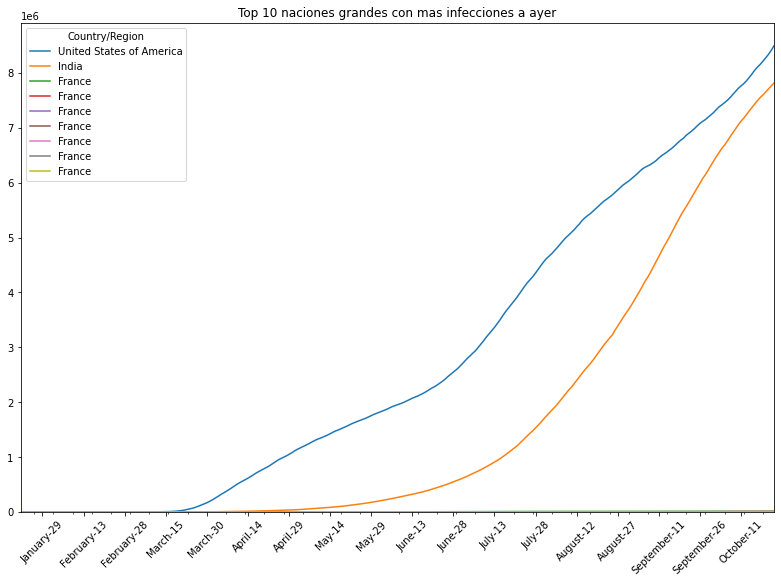

<module 'matplotlib.pyplot' from '/root/anaconda2/envs/jupyter/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [9]:
title="Top 10 naciones grandes con mas infecciones a ayer"
display(HTML(f"""<h1 id='{title}'>{title}</h1>"""))
df = get_data()

naciones_pintar = df_country.sort_values(by='infected last_day', ascending=False).head(10)['Country/Region'].values
df_country.sort_values(by='infected last_day', ascending=False).head(10)

pintar_grafico(df,naciones_pintar,title)



In [10]:
def pintar_grafico_daily(df, array_naciones_pintar ,title):
    df = df.T
    df = df.iloc[1:]
    new_header = df.iloc[0] #grab the first row for the header
    df = df[1:] #take the data less the header row
    df.columns = new_header #set the header row as the df header
    df = df.iloc[2:]
    df.index = pd.to_datetime(df.index)
    df = df[array_naciones_pintar]
    chart_df = df

    pd.plotting.register_matplotlib_converters()
    
    df_daily_increments = pd.DataFrame()
    for country in chart_df.columns:
        df_daily_increments[country] = chart_df[country].pct_change().rolling(window=7).mean()

    df_daily_increments    

    chart_df = df_daily_increments
    chart_df.tail(45).plot(legend=True,figsize=(13.5,9))

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%B-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
    plt.xticks(rotation=45)

    ax = plt.gca()

    ax.set_title(title)
    ax.set_ylim(ymin=0)

    plt.show()

    chart_df.tail(30).style.format ({ c : "{:20,.2f}" for c in df.columns }).background_gradient(cmap='Wistia', )


    return chart_df


#pintar_grafico_daily(df,naciones_pintar,"Top 10 countries more cases, daily percentage change")
df_country

,Country/Region,infected last_day,PopTotal,Infected/Million
0,Afghanistan,61,38928341,1.566982
1,Albania,306,2877800,106.331225
2,Algeria,273,43851043,6.225622
3,Andorra,227,77265,2937.940853
4,Angola,247,32866267,7.515304
...,...,...,...,...
242,Uzbekistan,285,33469199,8.515292
243,Western Sahara,0,597330,0.000000
244,Yemen,3,29825967,0.100583
245,Zambia,60,18383956,3.263715


In [11]:
#pintar_grafico_daily(df,naciones_pintar,"Top 10 countries more cases, daily percentage change")